# Import


In [1]:
import os
import math as m
from codes_gendrops_py.genSingleDrop import *
from codes_gendrops_py.fit_circle_through_3_points import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from cost_function import img2bw,ResizeImage
from PIL import Image
from remove_edge import *
import numpy as np

# Functions

In [2]:
#generate the synthetic image with r and z
def plt_image_needle(r_a,z_a,path,sigma,volume0,rneedle=1,l_needle=4):
    path=path+"/s%.2f_v%.2f_rn%.2f_ln%.2f_needle.jpg" %(sigma, volume0, rneedle,l_needle)
    plt.figure(figsize=(4,4))
    plt.plot(r_a,z_a,color='black')
    plt.plot(-r_a,z_a,color='black')
    
    plt.fill_between(r_a,l_needle,0,color='black')
    plt.fill_between(-r_a,l_needle,0,color='black')
    plt.fill_between(r_a,0,z_a,color='black')
    plt.fill_between(-r_a,0,z_a,color='black')

    plt.axis('equal')
    plt.axis('off')
    plt.savefig(path)
    plt.close()
    img=Image.open(path)
    return img,path

In [3]:
# cost function
def cost (x,y,img_syn,img_ori,K=1,output=0):
    '''
    input:              
    x,y:                the origin point of synthetic image
    img_syn,img_ori:    the images that need to calculate the cost 
                        should be valued by 'Image.open(path)'
    K:                  the scaling of synthethic image
    '''
    
    w_syn,h_syn=img_syn.size
    w_ori,h_ori=img_ori.size

    scaling_ori=100/w_ori # reshape the origin image to weight 100
    w_ori2=int(scaling_ori*w_ori)
    h_ori2=int(scaling_ori*h_ori)

    scaling_syn=K*scaling_ori
    w_syn2=int(scaling_syn*w_syn)
    h_syn2=int(scaling_syn*h_syn)

    x=int(x)
    y=int(y)

    A=img2bw(ResizeImage(img_ori,w_ori2,h_ori2))
    B=img2bw(ResizeImage(img_syn,w_syn2,h_syn2))
    C=np.zeros((w_ori2,h_ori2))

    for i in range (h_ori2): # h
        for j in range(w_ori2): # w
            #print(i,j)
            if i < y or i-y >= h_syn2 or j < x or j-x >= w_syn2:
                 C[i,j]=A[i,j]
            else:
                if  A[i,j]==B[i-y,j-x]:
                    C[i,j]=255
                else:
                    C[i,j]=0


    # pixel that same(T) different(F) and drop area
    t=0; f=0; 
    #drop_ori=0; drop_gen=0 
    for i in range (w_ori2):
        for j in range(h_ori2):
            if C[i,j]==0:
                f=f+1
            else:
                t=t+1


    lost=f/max(w_ori2*h_ori2,w_syn2*h_syn2)
    accurancy=1-lost

    if output == 0:
        return lost
    elif output == 1:
        return C
    else:
        return C,lost
    


# Program Start

## Obtimization

In [4]:
def obtimize_function(svlrxyk,path_ori=os.path.abspath('./images_experiment/220304_miliq_T17.7_S73.04.png'),path=os.path.abspath('./images_gen'),output=0):
    sigma =svlrxyk[0]
    v0    =svlrxyk[1]
    lNe   =svlrxyk[2]
    rNe   =svlrxyk[3]
    x     =svlrxyk[4]
    y     =svlrxyk[5]
    k     =svlrxyk[6]

    # generate the synthetic image
    r,z=genSingleDrop(savepath=path,sigma=sigma,volume0=v0,rneedle=rNe,output=1)
    img_syn,path_syn=plt_image_needle(r,z,path,sigma=sigma,volume0=v0,rneedle=rNe,l_needle=lNe)
    im = io.imread(path_syn)
    img_syn,path_syn = corp_margin(im)
    
    # open the origianl image
    img_ori=Image.open(path_ori)
    img_syn=Image.open(path_syn)
    # calulate the lost
    if output == 0:
        lost=cost(x,y,img_syn,img_ori,k,output=output)
        return lost
    elif output == 1:
        C=cost(x,y,img_syn,img_ori,k,output=output)
        return C
    else:
        C,lost = cost(x,y,img_syn,img_ori,k,output=output)
        return C,lost


## Start optimize

In [5]:
import scipy.optimize
# use scipy obtimaize the parameter
x0=np.asarray((75,20,2,0.5,30,0,1))
#sigma; v0; length_Ne,r_Ne; x,y; scaling_rate;
scipy.optimize.minimize(obtimize_function,x0,method='nelder-mead')


KeyboardInterrupt: 

### History
x0=np.asarray((75,20,4,1,20,1,1))
-->
x=np.array([77.46659107, 20.37480227,  3.6559882 ,  0.99864498, 21.43432356, 0.99075746,  1.00173946])

x0=np.asarray((75,20,2,0.5,30,0,1))
-->
x=np.array([ 8.11820316e+01,  2.09637535e+01,  2.14966986e+00,  5.10992904e-01, 2.58308160e+01, -1.59775216e-04,  9.41253105e-01])

In [6]:
#x=np.array([77.46659107, 20.37480227,  3.6559882 ,  0.99864498, 21.43432356, 0.99075746,  1.00173946])
x=np.array([ 8.11820316e+01,  2.09637535e+01,  2.14966986e+00,  5.10992904e-01, 2.58308160e+01, -1.59775216e-04,  9.41253105e-01])
C,lost=obtimize_function(x, output=2)


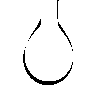

In [7]:
Image.fromarray(np.uint8(C))


In [ ]:
from matplotlib import pyplot as plt
plt.imshow(C, interpolation='nearest')
plt.show()